In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline



In [8]:
# df= pd.read_csv("../datasets/Phishing_Email.csv")
ling_df = pd.read_csv("../datasets/emails_model_testing_ling_ds.csv")
ling_df.head()

,subject,body,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [9]:
#fetching data from a different dataset and merging it
df_ceas = pd.read_csv("../datasets/CEAS_08.csv")
# for this training we're only interested in the subject, body and label
df_ceas = df_ceas[['subject', 'body', 'label']]

In [7]:
df_ceas.head()

,subject,body,label
0,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1
1,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1
2,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
3,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0
4,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1


In [10]:
df = pd.merge(ling_df, df_ceas, how="outer", on=None)

In [11]:
df.shape

(42013, 3)

In [19]:
# merging another one
nig_fraud_df = pd.read_csv("../datasets/Nigerian_Fraud.csv")
nig_fraud_df = nig_fraud_df[['subject', 'body', 'label']]
nig_fraud_df.head()

,subject,body,label
0,URGENT BUSINESS ASSISTANCE AND PARTNERSHIP,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...,1
1,URGENT ASSISTANCE /RELATIONSHIP (P),"Dear Friend,\n\nI am Mr. Ben Suleman a custom ...",1
2,GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,1
3,GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,1
4,I Need Your Assistance.,"Dear sir, \n \nIt is with a heart full of hope...",1


In [20]:
df = pd.merge(df, nig_fraud_df, how="outer", on=None)

In [21]:
df.shape

(45255, 3)

In [22]:
df.isna().sum()

subject    39
body        0
label       0
dtype: int64

In [23]:
df = df.dropna()
df.shape

(45216, 3)

In [24]:
email_type_counts = df['label'].value_counts()
print(email_type_counts)

label
1    25567
0    19649
Name: count, dtype: int64


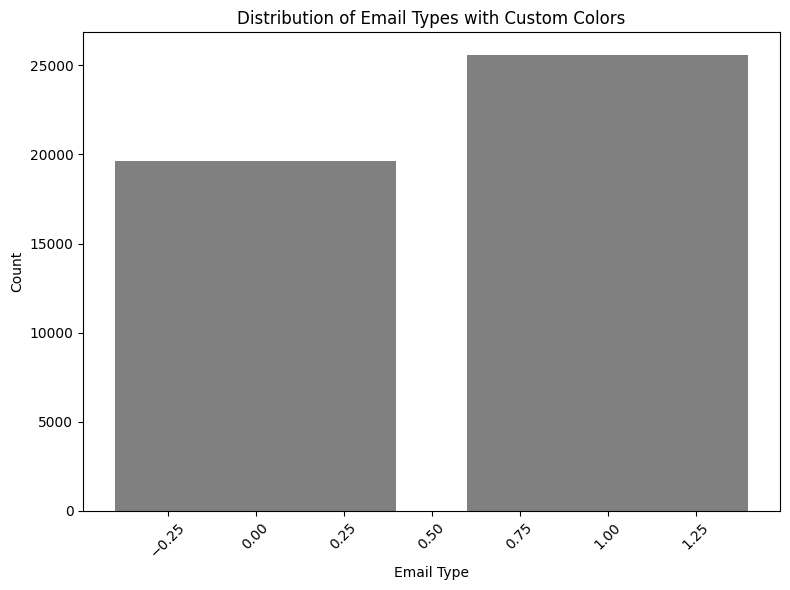

In [25]:
unique_email_types = email_type_counts.index.tolist()

color_map = {
    'Phishing Email': 'red',
    'Safe Email': 'green',}


colors = [color_map.get(email_type, 'gray') for email_type in unique_email_types]


plt.figure(figsize=(8, 6))
plt.bar(unique_email_types, email_type_counts, color=colors)
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.title('Distribution of Email Types with Custom Colors')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

In [26]:
# Safe_Email = df[df["Email Type"]== "Safe Email"]
# Phishing_Email = df[df["Email Type"]== "Phishing Email"]
Safe_Email = df[df["label"]==0]
Phishing_Email = df[df["label"]==1]
# Safe_Email = Safe_Email.sample(Phishing_Email.shape[0])
Phishing_Email = Phishing_Email.sample(Safe_Email.shape[0])

In [27]:
Safe_Email.shape,Phishing_Email.shape

((19649, 3), (19649, 3))

In [28]:
Data= pd.concat([Safe_Email, Phishing_Email], ignore_index = True).drop("subject", axis=1)
Data.head()

,body,label
0,content - length : 3386 apple-iss research cen...,0
1,i am posting this inquiry for sergei atamas ( ...,0
2,a colleague and i are researching the differin...,0
3,earlier this morning i was on the phone with a...,0
4,content - length : 4437 call for papers is the...,0


In [29]:
X = Data["body"].values
y = Data["label"].values

In [30]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [31]:
models = [
    (Pipeline([("tfidf", TfidfVectorizer()), ("classifier", RandomForestClassifier())]), {'classifier__n_estimators': [10]}),
    (Pipeline([("tfidf", TfidfVectorizer()), ("classifier", DecisionTreeClassifier())]), {'classifier__max_depth': [None, 10]}),
    (Pipeline([("tfidf", TfidfVectorizer()), ("classifier", AdaBoostClassifier())]), {'classifier__n_estimators': [50], 'classifier__learning_rate': [1.0]}),
    (Pipeline([("tfidf", TfidfVectorizer()), ("classifier", SGDClassifier())]), {'classifier__max_iter': [1000], 'classifier__tol': [1e-3]}),
    (Pipeline([("tfidf", TfidfVectorizer()), ("classifier", LogisticRegression())]), {'classifier__C': [1.0], 'classifier__max_iter': [100]})
]

###### Model => RandomForestClassifier
Test Accuracy : 98.06616%
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5866
           1       0.99      0.97      0.98      5924

    accuracy                           0.98     11790
   macro avg       0.98      0.98      0.98     11790
weighted avg       0.98      0.98      0.98     11790

Confusion Matrix


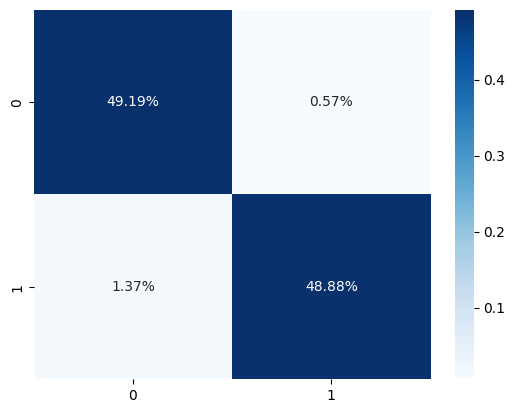

################### End ###################
###### Model => DecisionTreeClassifier
Test Accuracy : 96.78541%
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5866
           1       0.97      0.97      0.97      5924

    accuracy                           0.97     11790
   macro avg       0.97      0.97      0.97     11790
weighted avg       0.97      0.97      0.97     11790

Confusion Matrix


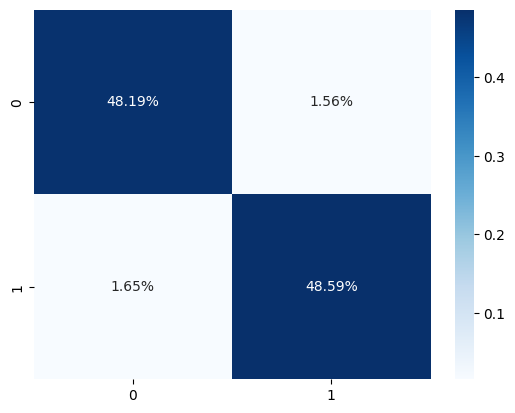

################### End ###################
###### Model => AdaBoostClassifier
Test Accuracy : 97.08227%
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5866
           1       0.96      0.98      0.97      5924

    accuracy                           0.97     11790
   macro avg       0.97      0.97      0.97     11790
weighted avg       0.97      0.97      0.97     11790

Confusion Matrix


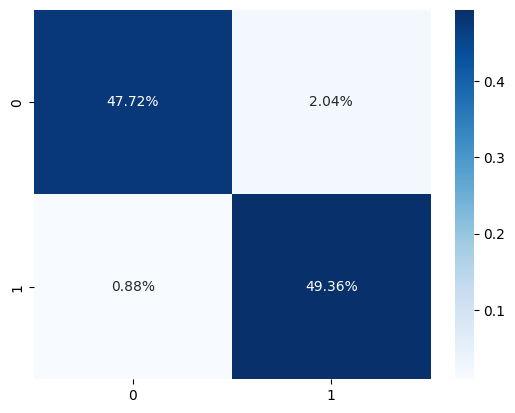

################### End ###################
###### Model => SGDClassifier
Test Accuracy : 99.38083%
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5866
           1       0.99      0.99      0.99      5924

    accuracy                           0.99     11790
   macro avg       0.99      0.99      0.99     11790
weighted avg       0.99      0.99      0.99     11790

Confusion Matrix


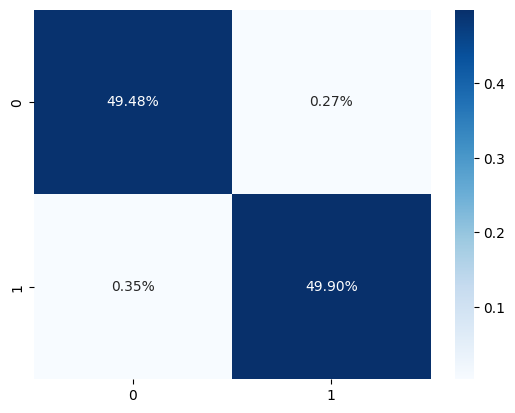

################### End ###################
###### Model => LogisticRegression
Test Accuracy : 99.01612%
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5866
           1       0.99      0.99      0.99      5924

    accuracy                           0.99     11790
   macro avg       0.99      0.99      0.99     11790
weighted avg       0.99      0.99      0.99     11790

Confusion Matrix


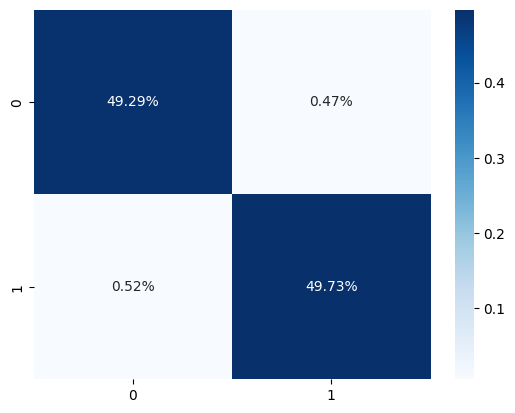

################### End ###################


In [32]:
accuracy_test = []
model_names = []

for pipeline, params in models:
    model_name = pipeline.steps[-1][1].__class__.__name__
    print(f'###### Model => {model_name}')
    
    grid_search = GridSearchCV(pipeline, params, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    accuracy_test.append(acc)
    model_names.append(model_name)
    
    print(f'Test Accuracy : {acc*100:.5f}%')
    print('Classification Report')
    print(classification_report(y_test, pred))
    print('Confusion Matrix')
    cf_matrix = confusion_matrix(y_test, pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
    plt.show()
    print('################### End ###################')

In [33]:
model_series = pd.Series(model_names, name='Model').astype(str)  
accuracy_series = pd.Series(accuracy_test, name='Accuracy')  
output = pd.concat([model_series, accuracy_series], axis=1)

In [34]:
output

,Model,Accuracy
0,RandomForestClassifier,0.980662
1,DecisionTreeClassifier,0.967854
2,AdaBoostClassifier,0.970823
3,SGDClassifier,0.993808
4,LogisticRegression,0.990161


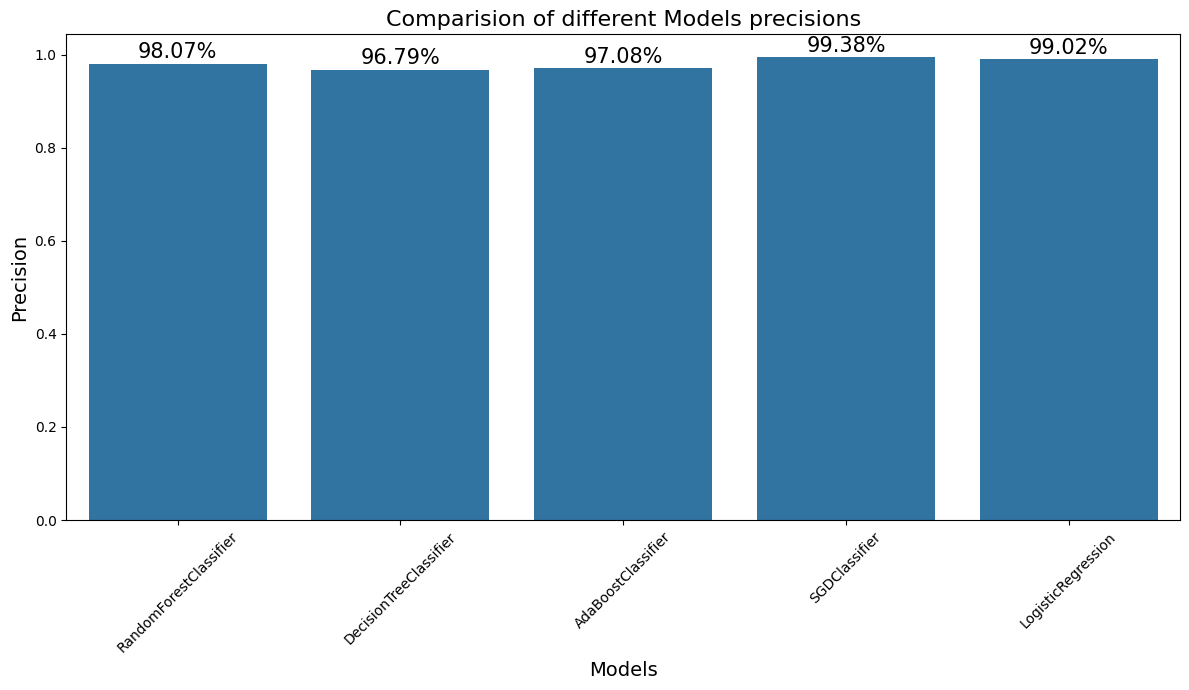

In [35]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2%'), 
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Comparision of different Models precisions", fontsize=16)  
plt.xticks(rotation=45)  
plt.tight_layout()  

plt.show()

In [37]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

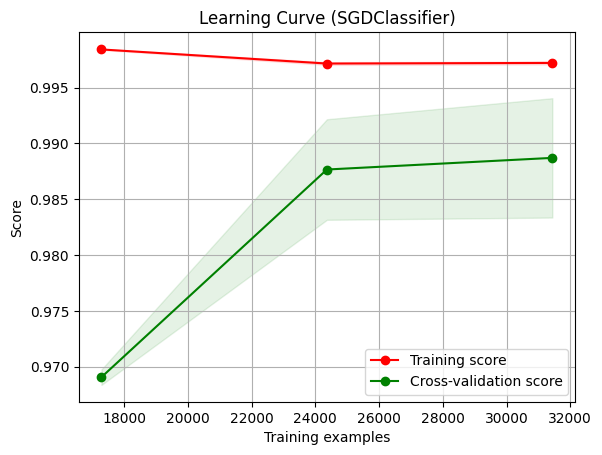

In [38]:
plot_learning_curve(models[3][0], "Learning Curve (SGDClassifier)", X, y, cv=5)
plt.show()

In [39]:
import joblib 
# Save the best model using joblib
joblib.dump(models[3][0], '../models/best_email_phishing_model.pkl')

['../models/best_email_phishing_model.pkl']